In [2]:
import pandas as pd
import seaborn as sns
import statistics
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.offsetbox import AnchoredText
import os
import math
import plotly.express as px
import plotly.graph_objects as go
import skbio
import numpy
import re

## Significant Pathways

In [26]:
Path_abund=pd.read_csv("Merged_Pathabundance_Table_CPM_meta.tsv",delimiter='\t')

Mapping_dict={}
for i in range(Path_abund.shape[0]):
    Mapping_dict['X'+str(i)]=Path_abund.iloc[i,0]
    Path_abund.iloc[i,0]='X'+str(i)
    
Path_abund.set_index(['Sample_ID'],inplace=True)
Path_abund.to_csv("Path_abundance_Temp.tsv")


In [27]:
Path_abund.columns=Path_abund.columns.str.replace("RCE","RCJ")

In [28]:
Sig_Results=pd.read_csv("./Pathways_MaAslin/significant_results.tsv",delimiter="\t")
Filter_By_pval=(Sig_Results['pval']<0.05)&(Sig_Results['qval']<0.05)
Sig_Results= Sig_Results.loc[Filter_By_pval]

In [29]:
Sex_Correlated=list(Sig_Results[Sig_Results['metadata']=='Sex']['feature'])
Sig_Results=Sig_Results[~Sig_Results['feature'].isin(Sex_Correlated)]
Sig_Results["feature"]=Sig_Results["feature"].apply(lambda x:Mapping_dict[x])

In [30]:
Sig_Results.to_csv("Significant_Pathways_Stats.csv")

In [31]:
Path_abund.reset_index(inplace=True)

In [32]:
Path_abund["Sample_ID"]=Path_abund["Sample_ID"].apply(lambda x:Mapping_dict[x])

In [35]:
Samples=list(Path_abund.columns[1:-1])
Group_Names=["Control","DSS","RCJ","RCJ_plus_DSS"]
Group_List=[]
for i in Samples:
    for j in Group_Names:
        if j in i and 'plus' not in i:
            Group_List.append(j)
            break
        elif "plus" in i:
            Group_List.append("RCJ_plus_DSS")
            break

group_map={Samples[i]:Group_List[i] for i in range(len(Samples))}
group_map["Start"]="Start"
Path_abund_lefse=Path_abund.copy()
Path_abund_lefse.columns=[group_map.get(i,Path_abund.columns[0]) for i in Path_abund.columns]

In [11]:
Path_abund_lefse.set_index("Sample_ID",inplace=True)

In [12]:
Path_abund_lefse.to_csv("Path_abund_cpm_lefse.csv")

In [13]:
Path_Abund_Filtered=Path_abund[Path_abund["Sample_ID"].isin(Sig_Results["feature"])]
Path_Abund_Filtered=Path_Abund_Filtered.reset_index(drop=True)


In [14]:
Path_Abund_Filtered.to_csv("Sig_results_abundance_path.csv")

In [15]:
Path_Abund_Unstratified_Filtered=Path_Abund_Filtered[~Path_Abund_Filtered['Sample_ID'].str.contains('|',regex=False)]
Path_Abund_Unstratified_Filtered=Path_Abund_Unstratified_Filtered.reset_index(drop=True)
Sig_Results.set_index("feature",inplace=True)

In [43]:
pallete=['rgb(150,150,150)','rgb(77,175,74)','rgb(55,126,184)','rgb(152,78,163)']
pallete_out=['rgb(150,150,150)','rgb(77,175,74)','rgb(55,126,184)','rgb(152,78,163)']

In [34]:
if not os.path.exists('Sig_Plots_Pathways_Unstratified/'):
    os.mkdir('Sig_Plots_Pathways_Unstratified/')
for pathway in Path_Abund_Unstratified_Filtered["Sample_ID"]:
    fig = go.Figure()
    temp_df={"Name":[],"Group":[],"Abundance":[],"Pooled":[]}
    for column in Path_Abund_Unstratified_Filtered.columns[1:-1]:
        temp_df["Name"].append(column)
        temp_df["Group"].append(group_map[column])
        temp_df["Abundance"].append(Path_Abund_Unstratified_Filtered.loc[Path_Abund_Unstratified_Filtered["Sample_ID"]==pathway,column].item())
        temp_df["Pooled"].append(True if "D_" in column else False)
    temp_df=pd.DataFrame(temp_df)
    
    for index,group in enumerate(["Control","DSS","RCJ","RCJ_plus_DSS"]):
        fig.add_trace(go.Box(
            y=temp_df[temp_df["Group"]==group]["Abundance"],
            name=group,
            boxpoints='all',
            jitter=0,
            marker_color=pallete[index],
            line_color=pallete[index],
            whiskerwidth=0.2,
            marker_size=10,
            line_width=1,
        pointpos = 0)
        )
    fig.add_trace(
        go.Scatter(
        mode='markers',
        x=temp_df[temp_df["Pooled"]==True]["Group"],
        y=temp_df[(temp_df["Pooled"]==True)]["Abundance"],
        name="Pooled",
        marker=dict(
            color='#7f7f7f',
            opacity=0.7,
            size=12,
            line=dict(
                color='black',
                width=1
            )),
        marker_symbol="cross"))


    fig.update_layout(
        title=f'{pathway}',
        title_font_size=15,
        title_x=0.5,
        title_xanchor='center',
        template='simple_white',
        yaxis=dict(
            autorange=True,
            showgrid=True,
            title={"text":"Pathway Abundance",
                  'font':{"size":15}},
            gridwidth=1,
            showline=True,

            
        ),
        xaxis=dict(
            title={"font":{"size":15},
                  "text":"Treatment Group"},
            showgrid=True,
            showline=True,

        ))
    if len(Sig_Results.loc[pathway].shape)>1:
        text_stat=f"Association:{Sig_Results.loc[pathway]['metadata'].iloc[0]}<br>P_value:{Sig_Results.loc[pathway]['pval'].iloc[0]:.1e}<br>Coefficient:{Sig_Results.loc[pathway]['coef'].iloc[0]:.1e}"
    else:
        text_stat=f"Association:{Sig_Results.loc[pathway]['metadata']}<br>P_value:{Sig_Results.loc[pathway]['pval']:.1e}<br>Coefficient:{Sig_Results.loc[pathway]['coef']:.1e}"
    fig.add_annotation(text=text_stat, 
                    align='left',
                    showarrow=False,
                    xref='paper',
                    yref='paper',
                    x=0.01,
                    y=1,
                    bordercolor='black',
                    borderwidth=1)

    
    fig.write_image(f"Sig_Plots_Pathways_Unstratified/{pathway}.svg")


    

In [35]:
arg=Path_abund[Path_abund["Sample_ID"].str.contains("ARGININE-SYN4-PWY: L-ornithine de novo  biosynthesis")]
his=Path_abund[Path_abund["Sample_ID"].str.contains("PWY-5030: L-histidine degradation III")]

In [39]:
if not os.path.exists('Sig_Plots_Pathways_Arginine/'):
    os.mkdir('Sig_Plots_Pathways_Arginine/')
for pathway in arg["Sample_ID"]:
    fig = go.Figure()
    temp_df={"Name":[],"Group":[],"Abundance":[],"Pooled":[]}
    for column in arg.columns[1:-1]:
        temp_df["Name"].append(column)
        temp_df["Group"].append(group_map[column])
        temp_df["Abundance"].append(arg.loc[arg["Sample_ID"]==pathway,column].item())
        temp_df["Pooled"].append(True if "D_" in column else False)
    temp_df=pd.DataFrame(temp_df)
    
    for index,group in enumerate(["Control","DSS","RCJ","RCJ_plus_DSS"]):
        fig.add_trace(go.Box(
            y=temp_df[temp_df["Group"]==group]["Abundance"],
            name=group,
            boxpoints='all',
            jitter=0,
            marker_color=pallete[index],
            line_color=pallete[index],
            whiskerwidth=0.2,
            marker_size=10,
            line_width=1,
        pointpos = 0)
        )
    fig.add_trace(
        go.Scatter(
        mode='markers',
        x=temp_df[temp_df["Pooled"]==True]["Group"],
        y=temp_df[(temp_df["Pooled"]==True)]["Abundance"],
        name="Pooled",
        marker=dict(
            color='#7f7f7f',
            opacity=0.7,
            size=12,
            line=dict(
                color='black',
                width=1
            )),
        marker_symbol="cross"))


    fig.update_layout(
        title=f'{pathway}',
        title_font_size=12,
        title_x=0.5,
        title_xanchor='center',
        template='simple_white',
        yaxis=dict(
            autorange=True,
            showgrid=True,
            title={"text":"Pathway Abundance",
                  'font':{"size":15}},
            gridwidth=1,
            showline=True,

            
        ),
        xaxis=dict(
            title={"font":{"size":15},
                  "text":"Treatment Group"},
            showgrid=True,
            showline=True,

        ))
    fig.write_image(f"Sig_Plots_Pathways_Arginine/{pathway}.svg")

In [40]:
if not os.path.exists('Sig_Plots_Pathways_Histidine/'):
    os.mkdir('Sig_Plots_Pathways_Histidine/')
for pathway in his["Sample_ID"]:
    fig = go.Figure()
    temp_df={"Name":[],"Group":[],"Abundance":[],"Pooled":[]}
    for column in his.columns[1:-1]:
        temp_df["Name"].append(column)
        temp_df["Group"].append(group_map[column])
        temp_df["Abundance"].append(his.loc[his["Sample_ID"]==pathway,column].item())
        temp_df["Pooled"].append(True if "D_" in column else False)
    temp_df=pd.DataFrame(temp_df)
    
    for index,group in enumerate(["Control","DSS","RCJ","RCJ_plus_DSS"]):
        fig.add_trace(go.Box(
            y=temp_df[temp_df["Group"]==group]["Abundance"],
            name=group,
            boxpoints='all',
            jitter=0,
            marker_color=pallete[index],
            line_color=pallete[index],
            whiskerwidth=0.2,
            marker_size=10,
            line_width=1,
        pointpos = 0)
        )
    fig.add_trace(
        go.Scatter(
        mode='markers',
        x=temp_df[temp_df["Pooled"]==True]["Group"],
        y=temp_df[(temp_df["Pooled"]==True)]["Abundance"],
        name="Pooled",
        marker=dict(
            color='#7f7f7f',
            opacity=0.7,
            size=12,
            line=dict(
                color='black',
                width=1
            )),
        marker_symbol="cross"))

    fig.update_layout(
        title=f'{pathway}',
        title_font_size=12,
        title_x=0.5,
        title_xanchor='center',
        template='simple_white',
        yaxis=dict(
            autorange=True,
            showgrid=True,
            title={"text":"Pathway Abundance",
                  'font':{"size":15}},
            gridwidth=1,
            showline=True,

            
        ),
        xaxis=dict(
            title={"font":{"size":15},
                  "text":"Treatment Group"},
            showgrid=True,
            showline=True,

        ))

        


    
    fig.write_image(f"Sig_Plots_Pathways_Histidine/{pathway}.svg")

## Megan Data

In [342]:
megan_species=pd.read_table("megan/STAMP/control_vs_DSS_vs_RCE_vs_RCEPlusDSS_species.tsv",delimiter="\t")
# megan_species=megan_species[megan_species["p-values (corrected)"]<0.05]
megan_species["Taxonomy"]=megan_species[megan_species.columns[:7]].apply(lambda x: "|".join(x.dropna().values.tolist()),axis=1)
megan_species_stat=megan_species[["Taxonomy","p-values (corrected)"]]

In [343]:
taxa_cols=["Taxonomy"]
taxa_cols=taxa_cols+[col for col in megan_species.columns if "rel. freq. (%)" in col]

In [344]:
rel_freqs=megan_species[taxa_cols]

In [345]:
rel_freqs.columns=[i.replace(": rel. freq. (%)","").strip() for i in rel_freqs.columns]
rel_freqs.columns=[i.replace("RCE","RCJ") for i in rel_freqs.columns]
rel_freqs_=rel_freqs.copy()
rel_freqs.drop([i for i in rel_freqs.columns if "mean rel. freq." in i],axis=1,inplace=True)


/var/folders/jk/fr50qn391k794svhntbw333c0000gn/T/ipykernel_83894/3050646591.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [336]:
if not os.path.exists("megan/sig_species_plots/"):   
    os.mkdir("megan/sig_species_plots/")
for taxon in rel_freqs_["Taxonomy"].unique():
    fig = go.Figure()
    temp_df={"Name":[],"Group":[],"Abundance":[],"Pooled":[]}
    for column in rel_freqs.columns[1:]:
        temp_df["Name"].append(column)
        temp_df["Group"].append(group_map[column])
        temp_df["Abundance"].append(rel_freqs.loc[rel_freqs["Taxonomy"]==taxon,column].item())
        temp_df["Pooled"].append(True if "D_" in column else False)
    temp_df=pd.DataFrame(temp_df)
    
    for index,group in enumerate(["Control","DSS","RCJ","RCJ_plus_DSS"]):
        fig.add_trace(go.Box(
            y=temp_df[temp_df["Group"]==group]["Abundance"],
            name=group,
            boxpoints='all',
            jitter=0,
            marker_color=pallete[index],
            line_color=pallete[index],
            whiskerwidth=0.2,
            marker_size=10,
            line_width=1,
        pointpos = 0)
        )
    fig.add_trace(
        go.Scatter(
        mode='markers',
        x=temp_df[temp_df["Pooled"]==True]["Group"],
        y=temp_df[(temp_df["Pooled"]==True)]["Abundance"],
        name="Pooled",
        marker=dict(
            color='#7f7f7f',
            opacity=0.7,
            size=12,
            line=dict(
                color='black',
                width=1
            )),
        marker_symbol="cross"))

    fig.update_layout(
        title=" ".join([re.sub("[a-z]__","",i) for i in taxon.split("|")[-1:]]),
        width=500,
        height=560,
        title_font_size=15,
        title_x=0.5,
        title_xanchor='center',
        template='simple_white',
        yaxis=dict(
            autorange=True,
            showgrid=True,
            title={"text":"Species Relative Abundance",
                  'font':{"size":15}},
            gridwidth=1,
            showline=True,

            
        ),
        xaxis=dict(
            title={"font":{"size":15},
                  "text":"Treatment Group"},
            showgrid=True,
            showline=True,

        ))


    fig.add_annotation(text=f"p-value: {megan_species_stat.loc[megan_species_stat['Taxonomy']==taxon,'p-values (corrected)'].item():.2e}",
                    align='left',
                    showarrow=False,
                    xref='paper',
                    yref='paper',
                    x=0.01,
                    y=1.05,
                    bordercolor='black',
                    borderwidth=1)
    fig.write_image(f"megan/sig_species_plots/{taxon}.svg")

In [346]:
rel_freqs.to_csv("megan/rel_freqs.csv",index=False)

In [347]:
import skbio.diversity.alpha as alpha

In [361]:
div={i:alpha.shannon(rel_freqs[i].to_list()) for i in rel_freqs.columns[1:]}
df={
    "Group":[],
    "Shannon":[]
}
for key,value in div.items():
    df["Group"].append(group_map[key])
    df["Shannon"].append(value)
df=pd.DataFrame(df)
fig = go.Figure()
for index,group in enumerate(["Control","DSS","RCJ","RCJ_plus_DSS"]):
    fig.add_trace(go.Box(
        y=df[df["Group"]==group]["Shannon"],
        name=group,
        boxpoints='all',
        jitter=0,
        marker_color=pallete[index],
        line_color=pallete[index],
        whiskerwidth=0.2,
        marker_size=10,
        line_width=1,
    pointpos = 0)
    )
fig.update_layout(
    title="Shannon Diversity",
    width=500,
    height=560,
    title_font_size=15,
    title_x=0.5,
    title_xanchor='center',
    template='simple_white',
    yaxis=dict(
        autorange=True,
        showgrid=True,
        title={"text":"Shannon Diversity",
                'font':{"size":15}},
        gridwidth=1,
        showline=True,
    ))
fig.write_image("megan/shannon_diversity.svg")

## Metaphlan diversity analysis 

In [30]:
arg=Path_abund[Path_abund["Sample_ID"].str.contains("ARGININE-SYN4-PWY: L-ornithine de novo  biosynthesis")]
his=Path_abund[Path_abund["Sample_ID"].str.contains("PWY-5030: L-histidine degradation III")]

In [31]:
if not os.path.exists('Sig_Plots_Pathways_Histidine/'):
    os.mkdir('Sig_Plots_Pathways_Histidine/')
for pathway in his["Sample_ID"]:
    fig = go.Figure()
    temp_df={"Name":[],"Group":[],"Abundance":[],"Pooled":[]}
    for column in his.columns[1:-1]:
        temp_df["Name"].append(column)
        temp_df["Group"].append(group_map[column])
        temp_df["Abundance"].append(his.loc[his["Sample_ID"]==pathway,column].item())
        temp_df["Pooled"].append(True if "D_" in column else False)
    temp_df=pd.DataFrame(temp_df)
    
    for index,group in enumerate(["Control","DSS","RCJ","RCJ_plus_DSS"]):
        fig.add_trace(go.Box(
            y=temp_df[temp_df["Group"]==group]["Abundance"],
            name=group,
            boxpoints='all',
            jitter=0,
            marker_color=pallete[index],
            line_color=pallete[index],
            whiskerwidth=0.2,
            marker_size=10,
            line_width=1,
        pointpos = 0)
        )
    fig.add_trace(
        go.Scatter(
        mode='markers',
        x=temp_df[temp_df["Pooled"]==True]["Group"],
        y=temp_df[(temp_df["Pooled"]==True)]["Abundance"],
        name="Pooled",
        marker=dict(
            color='#7f7f7f',
            opacity=0.7,
            size=12,
            line=dict(
                color='black',
                width=1
            )),
        marker_symbol="cross"))


    fig.update_layout(
        title=f'{pathway}',
        title_font_size=12,
        title_x=0.5,
        title_xanchor='center',

        yaxis=dict(
            autorange=True,
            showgrid=True,
            zeroline=True,
            title={"text":"Pathway Abundance",
                  'font':{"size":15}},
            gridcolor='rgb(255, 255, 255)',
            gridwidth=1,
            zerolinecolor='rgb(255, 255, 255)',
            zerolinewidth=2,
        ),
        xaxis=dict(
            title={"font":{"size":15},
                  "text":"Treatment Group"},

        ))
#     if len(Sig_Results.loc[pathway].shape)>1:
# #         text_stat=f"Association:{Sig_Results.loc[pathway]['metadata'].iloc[0]}<br>P_value:{Sig_Results.loc[pathway]['pval'].iloc[0]:.1e}<br>Coefficient:{Sig_Results.loc[pathway]['coef'].iloc[0]:.1e}"
# #     else:
# #         text_stat=f"Association:{Sig_Results.loc[pathway]['metadata']}<br>P_value:{Sig_Results.loc[pathway]['pval']:.1e}<br>Coefficient:{Sig_Results.loc[pathway]['coef']:.1e}"
#     fig.add_annotation(text=text_stat, 
#                     align='left',
#                     showarrow=False,
#                     xref='paper',
#                     yref='paper',
#                     x=0,
#                     y=1,
#                     bordercolor='black',
#                     borderwidth=1)

    
    fig.write_image(f"Sig_Plots_Pathways_Histidine/{pathway}.svg")

In [ ]:
Path_Abund_Unstratified_Filtered.set_index("Sample_ID",inplace=True)

In [ ]:
Samples=[i.replace("RCE","RCJ")for i in Samples]

In [ ]:
Path_Abund_Unstratified_Filtered.columns=Samples

In [21]:
Path_Abund_Unstratified_Filtered.set_index("Sample_ID",inplace=True)

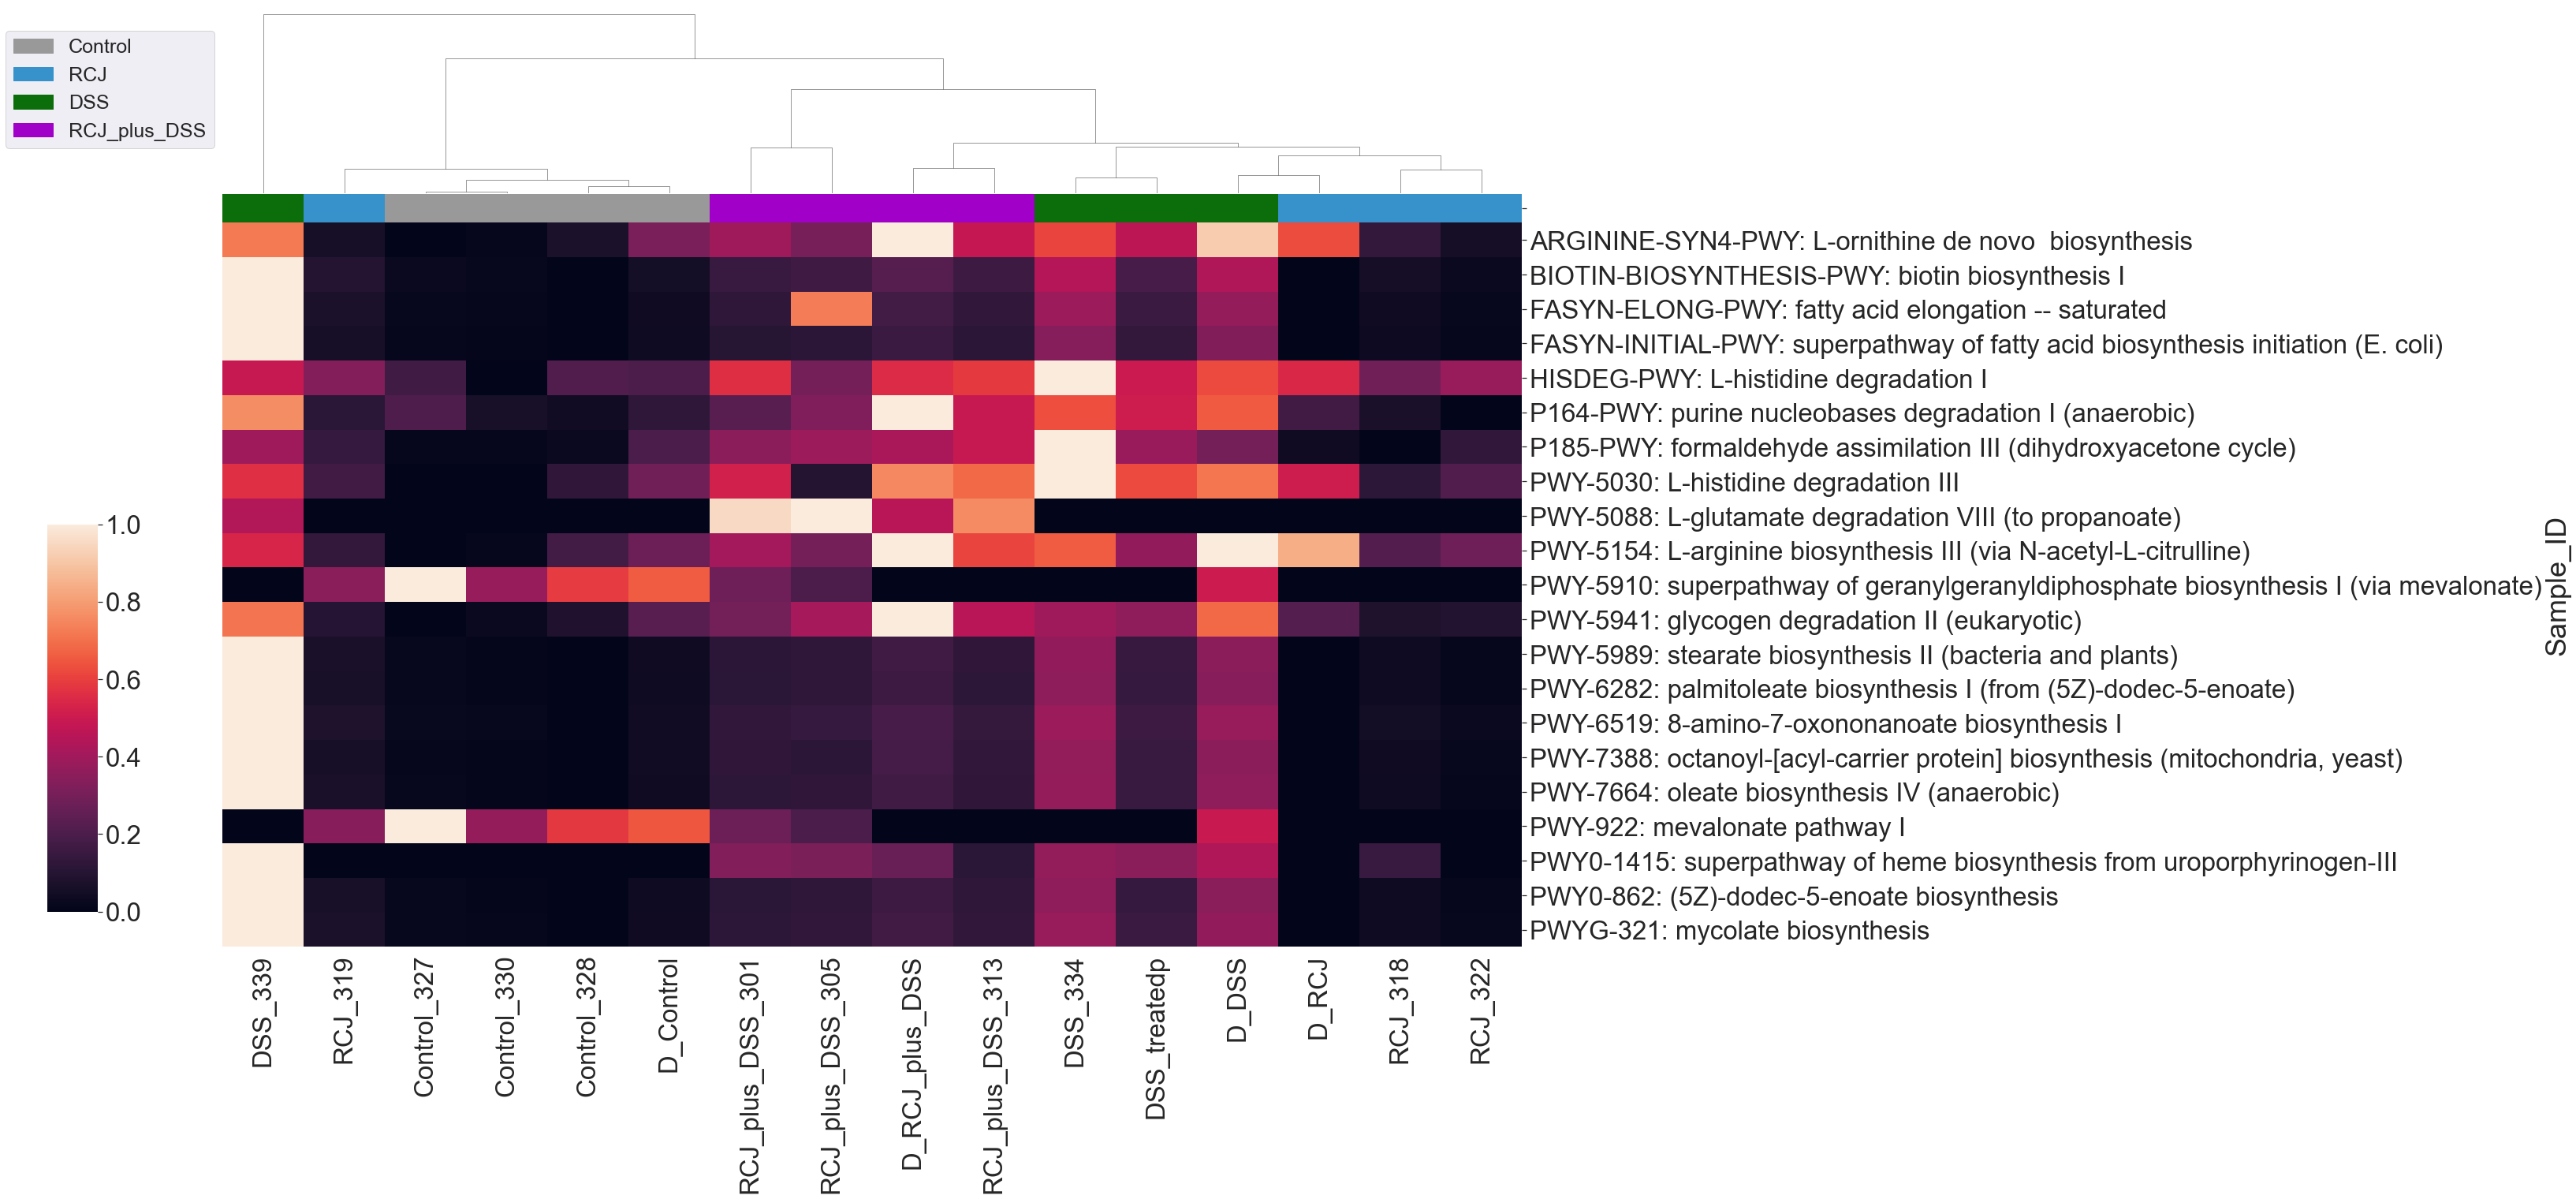

In [37]:
import seaborn
import matplotlib.patches as mpatches

Samples=list(Path_Abund_Unstratified_Filtered.columns)
palette = ["#999999", "#3792cb","#0b6e0b" , "#a000c8"]

Group_Names=["Control","RCJ","DSS","RCJ_plus_DSS"]
Group_List=[]
for i in Samples:
    for j in Group_Names:
        if j in i and 'plus' not in i:
            Group_List.append(j)
            break
        elif "plus" in i:
            Group_List.append("RCJ_plus_DSS")
            break

Color_dict={}
for i in range(len(Group_List)):
    Color_dict[Samples[i]]=palette[Group_Names.index(Group_List[i])]
Col_ser=pd.Series(Color_dict)
seaborn.set(font_scale=3)
ax=seaborn.clustermap(Path_Abund_Unstratified_Filtered.drop(columns=["Start"]),standard_scale=0,figsize=(45,22),row_cluster=False, metric="correlation",dendrogram_ratio=(.1, .2),cbar_pos=(0, .25, .02, .31),col_colors=Col_ser)

Patches=[]
for t in Group_Names:
    Patches.append(mpatches.Patch(color=palette[Group_Names.index(t)], label=t))

plt.legend(handles=Patches,loc='upper left',bbox_to_anchor=(-1, 1.8, 0.2, 0.5),fontsize='x-small')
ax.savefig("Sig_Plots_Pathways_Unstratified/Sig_Plots_Pathways_Unstratified.jpg")

In [ ]:
Path_Abund_Unstratified_Filtered

In [ ]:
Path_Abund_Unstratified_Filtered.reset_index(inplace=True)

In [ ]:
Heatmap_Dict={"Pathway":[],"DSS_only":[],"RCE_only":[],"RCEwDSS_only":[]}
DF=pd.DataFrame(Heatmap_Dict)
Counter=0
for i in Path_Abund_Unstratified_Filtered["Sample_ID"]:
    DF.loc[Counter]=[i,0,0,0]
    Temp=Sig_Results.loc[i,['metadata','coef','qval']]
    if len(Temp.shape)==1:
        DF.loc[Counter,Temp['metadata']]=-numpy.log(Temp['qval'])*numpy.sign(Temp['coef'])
    else:
        for k in range(Temp.shape[0]):
            DF.loc[Counter,Temp['metadata'][k]]=-numpy.log(Temp['qval'][k])*numpy.sign(Temp['coef'][k])
    Counter+=1
        
    
    

In [ ]:
DF.set_index('Pathway',inplace=True)

In [ ]:
T=seaborn.color_palette("coolwarm", as_cmap=True)


In [ ]:
seaborn.set(rc = {'figure.figsize':(25,12)})

ax=seaborn.heatmap(DF,cmap=T,linewidths=0.1, linecolor='white',square=True)
ax=ax.get_figure()    


ax.savefig('Sig_Plots_Pathways_Unstratified/Correlated_Pathways_Unstratified.jpg')

    


In [ ]:
Path_Abund_Stratified_Filtered=Path_Abund_Filtered[Path_Abund_Filtered['Sample_ID'].str.contains('|',regex=False)]
Path_Abund_Stratified_Filtered=Path_Abund_Stratified_Filtered.reset_index(drop=True)


In [ ]:
plt.figure(figsize=(6.5, 6.5), dpi=80)
if not os.path.exists('Sig_Plots_Pathways_Stratified/'):
    os.mkdir('Sig_Plots_Pathways_Stratified/')
for i in range(Path_Abund_Stratified_Filtered.shape[0]):
    x=[1,1,1,3,3,5,5,5,7,7,7]
    x1=list(np.linspace(0.5,1.5,100))
    x2=list(np.linspace(2.5,3.5,100))
    x3=list(np.linspace(4.5,5.5,100))
    x4=list(np.linspace(6.5,7.5,100))
    x5=[1,3,3,5,7]
    y=list(Path_Abund_Stratified_Filtered.iloc[i,[1,2,3,4,5,11,12,13,14,15,16]])
    y1=[statistics.median(y[0:3])]*len(x1)
    y2=[statistics.median(y[3:5])]*len(x1)
    y3=[statistics.median(y[5:8])]*len(x1)
    y4=[statistics.median(y[8:11])]*len(x1)
    y5=Path_Abund_Stratified_Filtered.iloc[i,[6,7,8,9,10]]
    ax1=plt.plot(x1,y1,x2,y2,x3,y3,x4,y4,color='k',linewidth=1,linestyle="--",label="Median")
    ax2=plt.scatter(x,y,s=40,cmap='summer',label="Individual")
    ax3=plt.scatter(x5,y5,s=40,cmap='r',marker=',',label="Pooled")
    plt.legend([ax1,ax2,ax3],["Median","Individual","Pooled"],loc='upper right',framealpha=0.5,edgecolor="black")
    plt.suptitle(Path_Abund_Stratified_Filtered.loc[i,"Sample_ID"],fontsize=7)
    plt.suptitle("\n".join(Path_Abund_Stratified_Filtered.loc[i,"Sample_ID"].split(":")),fontsize=12)
    plt.xticks([1,3,5,7],['Control','DSS','RCE','RCE+DSS'])
    top_DSS=plt.ylim()[1]-0.02*plt.ylim()[1]

    if len(Sig_Results.loc[Path_Abund_Stratified_Filtered.loc[i,"Sample_ID"]].shape)==1:     
        plt.text(0.3,top_DSS,Sig_Results.loc[Path_Abund_Stratified_Filtered.loc[i,"Sample_ID"],"metadata"]+": " + str(Sig_Results.loc[Path_Abund_Stratified_Filtered.loc[i,"Sample_ID"],"value"])+"\n\nCoeff: "+ str(Sig_Results.loc[Path_Abund_Stratified_Filtered.loc[i,"Sample_ID"],"coef"])[0:5]+"\n\nP_value: "+str(format(Sig_Results.loc[Path_Abund_Stratified_Filtered.loc[i,"Sample_ID"],"pval"],'f'))+"\n\nQ_value: "+str(format(Sig_Results.loc[Path_Abund_Stratified_Filtered.loc[i,"Sample_ID"],"qval"],'f')),fontsize=10,verticalalignment="top")
    else:
        plt.text(0.3,top_DSS,Sig_Results.loc[Path_Abund_Stratified_Filtered.loc[i,"Sample_ID"],"metadata"].iloc[0]+": " + str(Sig_Results.loc[Path_Abund_Stratified_Filtered.loc[i,"Sample_ID"],"value"].iloc[0])+"\n\nCoeff: "+ str(Sig_Results.loc[Path_Abund_Stratified_Filtered.loc[i,"Sample_ID"],"coef"].iloc[0])[0:5]+"\n\nP_value: "+str(format(Sig_Results.loc[Path_Abund_Stratified_Filtered.loc[i,"Sample_ID"],"pval"].iloc[0],'f'))+"\n\nQ_value: "+str(format(Sig_Results.loc[Path_Abund_Stratified_Filtered.loc[i,"Sample_ID"],"qval"].iloc[0],'f')),fontsize=10,verticalalignment="top")

    
    
    plt.xlabel("Treatment Group")
    plt.ylabel("Path Abundances")
    plt.tight_layout()

    plt.savefig("Sig_Plots_Pathways_Stratified/"+Path_Abund_Stratified_Filtered.loc[i,"Sample_ID"][0:6],dpi=300)
    plt.cla()

## Significant Reactions 

In [ ]:
Rxn_abund=pd.read_csv("./rxn-cpm.txt",delimiter='\t')
Mapping_dict={}
for i in range(Rxn_abund.shape[0]):
    Mapping_dict['X'+str(i)]=Rxn_abund.iloc[i,0]
    Rxn_abund.iloc[i,0]='X'+str(i)
  
Rxn_abund.set_index(['Sample_ID'],inplace=True)
Rxn_abund.to_csv("Rxn_abundance_Temp.tsv")

In [ ]:
Sig_Results=pd.read_csv("./Rxns_MaAslin/significant_results.tsv",delimiter="\t")
Filter_By_pval=(Sig_Results['pval']<0.05)&(Sig_Results['qval']<0.1)
Sig_Results= Sig_Results.loc[Filter_By_pval]


In [ ]:
Sex_Correlated=list(Sig_Results[Sig_Results['metadata']=='Sex']['feature'])
Sig_Results=Sig_Results[~Sig_Results['feature'].isin(Sex_Correlated)]
Sig_Results["feature"]=Sig_Results["feature"].apply(lambda x:Mapping_dict[x])

In [ ]:
Rxn_abund.reset_index(inplace=True)

In [ ]:
for i in range(Rxn_abund.shape[0]):
       Rxn_abund.loc[i,"Sample_ID"]=Mapping_dict[Rxn_abund.loc[i,"Sample_ID"]]


In [ ]:
Rxn_Abund_Filtered=Rxn_abund[Rxn_abund["Sample_ID"].isin(Sig_Results["feature"])]          
Rxn_Abund_Filtered=Rxn_Abund_Filtered.reset_index(drop=True)

In [ ]:
Rxn_Abund_Unstratified_Filtered=Rxn_Abund_Filtered[~Rxn_Abund_Filtered['Sample_ID'].str.contains('|',regex=False)]
Rxn_Abund_Unstratified_Filtered=Rxn_Abund_Unstratified_Filtered.reset_index(drop=True)

In [ ]:
Sig_Results.set_index("feature",inplace=True)

In [ ]:
Sig_Results.to_csv("Significant_Reactions_Stats.csv")

In [ ]:
plt.figure(figsize=(6, 6), dpi=80)
if not os.path.exists('Sig_Plots_Rxns_Unstratified/'):
    os.mkdir('Sig_Plots_Rxns_Unstratified/')
for i in range(Rxn_Abund_Unstratified_Filtered.shape[0]):
    x=[1,1,1,3,3,5,5,5,7,7,7]
    x1=list(np.linspace(0.5,1.5,100))
    x2=list(np.linspace(2.5,3.5,100))
    x3=list(np.linspace(4.5,5.5,100))
    x4=list(np.linspace(6.5,7.5,100))
    x5=[1,3,3,5,7]
    y=list(Rxn_Abund_Unstratified_Filtered.iloc[i,[1,2,3,4,5,11,12,13,14,15,16]])
    y1=[statistics.median(y[0:3])]*len(x1)
    y2=[statistics.median(y[3:5])]*len(x1)
    y3=[statistics.median(y[5:8])]*len(x1)
    y4=[statistics.median(y[8:11])]*len(x1)
    y5=Rxn_Abund_Unstratified_Filtered.iloc[i,[6,7,8,9,10]]
    plt.plot(x1,y1,x2,y2,x3,y3,x4,y4,color='k',linewidth=1,linestyle="--")
    plt.scatter(x,y,s=25,cmap='summer')
    plt.scatter(x5,y5,s=30,cmap='r',marker=',')
    plt.suptitle(Rxn_Abund_Unstratified_Filtered.loc[i,"Sample_ID"],fontsize=7)
    plt.xticks([1,3,5,7],['Control','DSS','RCE','RCE+DSS'])
    top_DSS=plt.ylim()[1]-1
    if len(Sig_Results.loc[Rxn_Abund_Unstratified_Filtered.loc[i,"Sample_ID"]].shape)==1:     
        plt.text(6,top_DSS,Sig_Results.loc[Rxn_Abund_Unstratified_Filtered.loc[i,"Sample_ID"],"metadata"]+": " + str(Sig_Results.loc[Rxn_Abund_Unstratified_Filtered.loc[i,"Sample_ID"],"value"])+"\n\nCoeff: "+ str(Sig_Results.loc[Rxn_Abund_Unstratified_Filtered.loc[i,"Sample_ID"],"coef"])[0:5]+"\n\nP_value: "+str(format(Sig_Results.loc[Rxn_Abund_Unstratified_Filtered.loc[i,"Sample_ID"],"pval"],'f'))+"\n\nQ_value: "+str(format(Sig_Results.loc[Rxn_Abund_Unstratified_Filtered.loc[i,"Sample_ID"],"qval"],'f')),fontsize=9,verticalalignment="top")
    else:
        plt.text(6,top_DSS,Sig_Results.loc[Rxn_Abund_Unstratified_Filtered.loc[i,"Sample_ID"],"metadata"].iloc[0]+": " + str(Sig_Results.loc[Rxn_Abund_Unstratified_Filtered.loc[i,"Sample_ID"],"value"].iloc[0])+"\n\nCoeff: "+ str(Sig_Results.loc[Rxn_Abund_Unstratified_Filtered.loc[i,"Sample_ID"],"coef"].iloc[0])[0:5]+"\n\nP_value: "+str(format(Sig_Results.loc[Rxn_Abund_Unstratified_Filtered.loc[i,"Sample_ID"],"pval"].iloc[0],'f'))+"\n\nQ_value: "+str(format(Sig_Results.loc[Rxn_Abund_Unstratified_Filtered.loc[i,"Sample_ID"],"qval"].iloc[0],'f')),fontsize=9,verticalalignment="top")
    plt.xlabel("Treatment Group")
    plt.ylabel("Path Abundances")
    plt.savefig("Sig_Plots_Rxns_Unstratified/"+Rxn_Abund_Unstratified_Filtered.loc[i,"Sample_ID"][0:20].replace(': ','')+'.png',dpi=300)
    plt.cla()

In [ ]:
Heatmap_Dict={"Rxn":[],"DSS_only":[],"RCE_only":[],"RCEwDSS_only":[]}
DF=pd.DataFrame(Heatmap_Dict)
Counter=0
for i in Rxn_Abund_Unstratified_Filtered["Sample_ID"]:
    DF.loc[Counter]=[i,0,0,0]
    Temp=Sig_Results.loc[i,['metadata','coef','qval']]
    if len(Temp.shape)==1:
        DF.loc[Counter,Temp['metadata']]=-np.log(Temp['qval'])*np.sign(Temp['coef'])
    else:
        for k in range(Temp.shape[0]):
            DF.loc[Counter,Temp['metadata'][k]]=-np.log(Temp['qval'][k])*np.sign(Temp['coef'][k])
    Counter+=1
DF.set_index("Rxn",inplace=True)

In [ ]:
seaborn.set(rc = {'figure.figsize':(25,12)})


T=seaborn.color_palette("coolwarm", as_cmap=True)

for i in range(math.floor(DF.shape[0]/20)):
    if (i+1)*20<DF.shape[0]:
        ax=seaborn.heatmap(DF.iloc[20*i:20*(i+1)],cmap=T,linewidths=1, linecolor='white',square=True)

    else:
        ax=seaborn.heatmap(DF.iloc[20*i:],cmap=T,linewidths=1, linecolor='white',square=True)

    ax=ax.get_figure()    
    ax.savefig('Sig_Plots_Rxns_Unstratified/Rxn_Heatmap'+str(i))
    plt.clf()
    

In [ ]:
Sig_Results.reset_index(inplace=True)

In [ ]:
Sig_Results[Sig_Results['feature'].str.contains('|',regex=False)]

In [ ]:
Rxn_Abund_Filtered=Rxn_abund[Rxn_abund["Sample_ID"].isin(Sig_Results["feature"])]

In [ ]:
Rxn_Abund_Stratified_Filtered=Rxn_Abund_Filtered[Rxn_Abund_Filtered['Sample_ID'].str.contains('|',regex=False)]
Rxn_Abund_Stratified_Filtered=Rxn_Abund_Stratified_Filtered.reset_index(drop=True)


In [ ]:
Sig_Results.set_index("feature",inplace=True)

### DO NOT RUN THE FOLLOWING UNLESS YOU HAVE TIME AND SPACE FOR THOUSANDS OF PLOTS

In [ ]:
plt.figure(figsize=(6, 6), dpi=80)
if not os.path.exists('Sig_Plots_Rxns_Stratified/'):
    os.mkdir('Sig_Plots_Rxns_Stratified/')
for i in range(Rxn_Abund_Stratified_Filtered.shape[0]):
    x=[1,1,1,3,3,5,5,5,7,7,7]
    x1=list(np.linspace(0.5,1.5,100))
    x2=list(np.linspace(2.5,3.5,100))
    x3=list(np.linspace(4.5,5.5,100))
    x4=list(np.linspace(6.5,7.5,100))
    x5=[1,3,3,5,7]
    y=list(Rxn_Abund_Stratified_Filtered.iloc[i,[1,2,3,4,5,11,12,13,14,15,16]])
    y1=[statistics.median(y[0:3])]*len(x1)
    y2=[statistics.median(y[3:5])]*len(x1)
    y3=[statistics.median(y[5:8])]*len(x1)
    y4=[statistics.median(y[8:11])]*len(x1)
    y5=Rxn_Abund_Stratified_Filtered.iloc[i,[6,7,8,9,10]]
    plt.plot(x1,y1,x2,y2,x3,y3,x4,y4,color='k',linewidth=1,linestyle="--")
    plt.scatter(x,y,s=25,cmap='summer')
    plt.scatter(x5,y5,s=30,cmap='r',marker=',')
    plt.suptitle(Rxn_Abund_Stratified_Filtered.loc[i,"Sample_ID"],fontsize=7)
    plt.xticks([1,3,5,7],['Control','DSS','RCE','RCE+DSS'])
    top_DSS=plt.ylim()[1]-1
    if len(Sig_Results.loc[Rxn_Abund_Stratified_Filtered.loc[i,"Sample_ID"]].shape)==1:     
        plt.text(6,top_DSS,Sig_Results.loc[Rxn_Abund_Stratified_Filtered.loc[i,"Sample_ID"],"metadata"]+": " + str(Sig_Results.loc[Rxn_Abund_Stratified_Filtered.loc[i,"Sample_ID"],"value"])+"\n\nCoeff: "+ str(Sig_Results.loc[Rxn_Abund_Stratified_Filtered.loc[i,"Sample_ID"],"coef"])[0:5]+"\n\nP_value: "+str(format(Sig_Results.loc[Rxn_Abund_Stratified_Filtered.loc[i,"Sample_ID"],"pval"],'f'))+"\n\nQ_value: "+str(format(Sig_Results.loc[Rxn_Abund_Stratified_Filtered.loc[i,"Sample_ID"],"qval"],'f')),fontsize=9,verticalalignment="top")
    else:
        plt.text(6,top_DSS,Sig_Results.loc[Rxn_Abund_Stratified_Filtered.loc[i,"Sample_ID"],"metadata"].iloc[0]+": " + str(Sig_Results.loc[Rxn_Abund_Stratified_Filtered.loc[i,"Sample_ID"],"value"].iloc[0])+"\n\nCoeff: "+ str(Sig_Results.loc[Rxn_Abund_Stratified_Filtered.loc[i,"Sample_ID"],"coef"].iloc[0])[0:5]+"\n\nP_value: "+str(format(Sig_Results.loc[Rxn_Abund_Stratified_Filtered.loc[i,"Sample_ID"],"pval"].iloc[0],'f'))+"\n\nQ_value: "+str(format(Sig_Results.loc[Rxn_Abund_Stratified_Filtered.loc[i,"Sample_ID"],"qval"].iloc[0],'f')),fontsize=9,verticalalignment="top")
    plt.xlabel("Treatment Group")
    plt.ylabel("Path Abundances")
    plt.savefig("Sig_Plots_Rxns_Stratified/"+Rxn_Abund_Stratified_Filtered.loc[i,"Sample_ID"][0:6]+'.png',dpi=300)
    plt.cla()

## Some Further Analysis

Tables Needed:

- Path_Abund_Stratified_Filtered
- Rxn_Abund_Unstratified_Filtered
- Path_Abund_Unstratified_Filtered

**Question 1:**

-	Several reactions that look apparently higher in DSS+RCJ but low in DSS and controlonly are alpha-L-focusidase: 
        - ALPHA-L-FOCUSIDEASE 
        - RXN-19378
        - RXN-19379
        - The figures all look the same, so they are probably from the same gene
        - Can you check if this gene/reaction is significantly higher in DSS+RCJ vs. DSS? It might not since one sample in DSS+RCJ is at the same level as DSS but two others are about 2-fold higher.


In [ ]:
from scipy.stats import ttest_ind


In [ ]:
Q1_List=["ALPHA","RXN-19378","RXN-19379"]
Q1_DF=Rxn_Abund_Unstratified_Filtered[Rxn_Abund_Unstratified_Filtered["Sample_ID"].str.contains("Something_Werid")]
for i in range(len(Q1_List)):
    Q1_DF=Q1_DF.append(Rxn_Abund_Unstratified_Filtered[Rxn_Abund_Unstratified_Filtered["Sample_ID"].str.contains(Q1_List[i])])
    
Q1_DF=Q1_DF.iloc[:,[4,5,-4,-3,-2]]

In [ ]:
Desired_Species=["d__Bacteria|p__Firmicutes|c__Clostridia|o__Eubacteriales|f__Lachnospiraceae|g__Roseburia|s__Roseburia intestinalis",
                 "d__Bacteria|p__Firmicutes|c__Clostridia|o__Eubacteriales|f__Lachnospiraceae|g__Roseburia|s__Roseburia hominis",
                "d__Bacteria|p__Firmicutes|c__Clostridia|o__Eubacteriales|f__Oscillospiraceae|g__Faecalibacterium|s__Faecalibacterium prausnitzii",
                "d__Bacteria|p__Verrucomicrobia|c__Verrucomicrobiae|o__Verrucomicrobiales|f__Akkermansiaceae|g__Akkermansia|s__Akkermansia muciniphila",
                "k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Lactobacillaceae|g__Lactobacillus|s__Lactobacillus_johnsonii",
                "k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Bifidobacteriales|f__Bifidobacteriaceae|g__Bifidobacterium|s__Bifidobacterium_pseudolongum",
                "k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Oscillospiraceae|g__Oscillibacter|s__Oscillibacter_sp_1_3",
                "k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Lachnospiraceae|g__Dorea|s__Dorea_sp_5_2",
                "k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Lachnospiraceae|g__Lachnospiraceae_unclassified|s__Lachnospiraceae_bacterium_10_1",
                 "k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Lachnospiraceae|g__Acetatifactor|s__Acetatifactor_muris"
                ]

In [ ]:
Metaphlan=pd.read_table("Merge_Metaphlan_Clean.tsv")
Kraken_TSS=pd.read_table("Species_TSS.csv",delimiter=",")
Kraken_CSS=pd.read_table("Species_Normalized.txt",delimiter="\t")

In [ ]:
Metaphlan=Metaphlan.reindex(sorted(Metaphlan.columns), axis=1).set_index("clade_name").reset_index()
Metaphlan.drop("NCBI_tax_id",axis=1,inplace=True)

In [ ]:
Met_Cols=["clade_name"]
[Met_Cols.append(colname.strip("_metaphlan_bugs_list")) for colname in Metaphlan.columns if "_metaphlan_bugs_list" in colname]

In [ ]:
Dict={}
for i in range(len(Metaphlan.columns)):
    Dict[Metaphlan.columns[i]]=Met_Cols[i]

Dict["Start_metaphlan_bugs_list"]="Start"
Dict["clade_name"]="Taxon"
Dict["DSS_treatedp_metaphlan_bugs_list"]="DSS_treatedp"
Dict["DSS_treatedp_metaphlan_bugs_list"]="DSS_treatedp"
Dict['D_Control_metaphlan_bugs_list']="D_Control"

Metaphlan.rename(Dict,inplace=True,axis=1)
Kraken_TSS.rename({"Taxonomy":"Taxon"},inplace=True,axis=1)

In [ ]:
Final_Table=pd.DataFrame(columns = Metaphlan.columns)

In [ ]:
for Bac in Desired_Species:
    if Bac in list(Metaphlan["Taxon"]):
        Final_Table=Final_Table.append(Metaphlan[Metaphlan["Taxon"]==Bac])
    else:
        Final_Table=Final_Table.append(Kraken_TSS[Kraken_TSS["Taxon"]==Bac])
        

In [ ]:
Bac_Names=list([name[-1].strip("s__") for name in Final_Table["Taxon"].str.split("|")])

In [ ]:
fig,axs=plt.subplots(int(Final_Table.shape[0]/2),2,figsize=(4.5, 13),sharex=True,constrained_layout=False)
for i in range(Final_Table.shape[0]):
    x=[1,1,1,3,3,5,5,5,7,7,7]
    x1=list(np.linspace(0.5,1.5,100))
    x2=list(np.linspace(2.5,3.5,100))
    x3=list(np.linspace(4.5,5.5,100))
    x4=list(np.linspace(6.5,7.5,100))
    x5=[1,3,3,5,7]
    y=list(Final_Table.iloc[i,[1,2,3,4,5,11,12,13,14,15,16]])
    y1=[statistics.median(y[0:3])]*len(x1)
    y2=[statistics.median(y[3:5])]*len(x1)
    y3=[statistics.median(y[5:8])]*len(x1)
    y4=[statistics.median(y[8:11])]*len(x1)
    y5=Final_Table.iloc[i,[6,7,8,9,10]]
    axs[math.floor(i/2),i%2].plot(x1,y1,x2,y2,x3,y3,x4,y4,color='k',linewidth=1,linestyle="--")
    axs[math.floor(i/2),i%2].scatter(x,y,s=50,cmap='summer')
#     axs[math.floor(i/2),i%2].scatter(x5,y5,s=70,cmap='r',marker=',')

    axs[math.floor(i/2),i%2].set_xticks([1,3,5,7],['Control','DSS','RCJ','RCJ+DSS'],fontsize=8.5)
    axs[math.floor(i/2),i%2].set_yticks(axs[math.floor(i/2),i%2].get_yticks(),fontsize=50)    
    axs[math.floor(i/2),i%2].set_title(Bac_Names[i],fontsize=10.5)
fig.text(0.5, 0, 'Treatment Group', ha='center',fontsize=15)
fig.text(0, 0.5, 'Relative Abundance %', va='center', rotation='vertical',fontsize=15)
fig.tight_layout(pad=0.2)
fig.subplots_adjust(bottom=0.05)
fig.savefig("Taxa_of_Interest.png",dpi=600,bbox_inches="tight")

In [ ]:
Desired_Items=["AMINOGLYCOSIDE-N3-ACETYLTRANSFERASE-RXN",
               "PWY-5910: superpathway of geranylgeranyldiphosphate biosynthesis I (via mevalonate)",
               "TAURINE-AMINOTRANSFERASE-RXN",
               "RXN-20702",
               "GLUDEG-I-PWY: GABA shunt|g__Lactobacillus.s__Lactobacillus_reuteri",
               "LACTOSECAT-PWY: lactose and galactose degradation I|g__Lactobacillus.s__Lactobacillus_johnsonii"]
Item_Name=["AMINOGLYCOSIDE-N3-ACETYLTRANSFERASE".lower(),
           "superpathway of geranylgeranyldiphosphate biosynthesis",
           "TAURINE-AMINOTRANSFERASE".lower(),
           "isethionate sulfite-lyase",
          "GABA shunt: Lactobacillus_reuteri",
          "lactose and galactose degradation I: Lactobacillus_johnsonii"
          ]               

In [ ]:
Path_abund=pd.read_csv("Merged_Pathabundance_Table_CPM_meta.tsv",delimiter='\t')
Rxn_abund=pd.read_csv("./rxn-cpm.txt",delimiter='\t')

In [ ]:
Final_Table=pd.DataFrame(columns = Path_abund.columns)

In [ ]:
for item in Desired_Items:
    if item in list(Path_abund["Sample_ID"]):
        Final_Table=Final_Table.append(Path_abund[Path_abund["Sample_ID"]==item])
    else:
        Final_Table=Final_Table.append(Rxn_abund[Rxn_abund["Sample_ID"]==item])
        

In [39]:
megan_phylum=pd.read_table("megan/STAMP/control_vs_DSS_vs_RCE_vs_RCEPlusDSS_phylum.tsv",delimiter='\t')
taxa_cols=["Phylum"]
taxa_cols=taxa_cols+[col for col in megan_phylum.columns if "rel. freq. (%)" in col and "mean rel. freq. (%)" not in col]


In [40]:
megan_phylum=megan_phylum[taxa_cols]
megan_phylum.columns=megan_phylum.columns.str.replace(": rel. freq. (%)","",regex=False)
megan_phylum.columns=megan_phylum.columns.str.replace("RCE","RCJ",regex=False)

In [44]:
if not os.path.exists("megan/sig_phylum_plots/"):   
    os.mkdir("megan/sig_phylum_plots/")
for taxon in megan_phylum["Phylum"].unique():
    fig = go.Figure()
    temp_df={"Name":[],"Group":[],"Abundance":[],"Pooled":[]}
    for column in megan_phylum.columns[1:]:
        temp_df["Name"].append(column)
        temp_df["Group"].append(group_map[column])
        temp_df["Abundance"].append(megan_phylum.loc[megan_phylum["Phylum"]==taxon,column].item())
        temp_df["Pooled"].append(True if "D_" in column else False)
    temp_df=pd.DataFrame(temp_df)
    
    for index,group in enumerate(["Control","DSS","RCJ","RCJ_plus_DSS"]):
        fig.add_trace(go.Box(
            y=temp_df[temp_df["Group"]==group]["Abundance"],
            name=group,
            boxpoints='all',
            jitter=0,
            marker_color=pallete[index],
            line_color=pallete[index],
            whiskerwidth=0.2,
            marker_size=10,
            line_width=1,
        pointpos = 0)
        )
    fig.add_trace(
        go.Scatter(
        mode='markers',
        x=temp_df[temp_df["Pooled"]==True]["Group"],
        y=temp_df[(temp_df["Pooled"]==True)]["Abundance"],
        name="Pooled",
        marker=dict(
            color='#7f7f7f',
            opacity=0.7,
            size=12,
            line=dict(
                color='black',
                width=1
            )),
        marker_symbol="cross"))

    fig.update_layout(
        title=" ".join([re.sub("[a-z]__","",i) for i in taxon.split("|")[-1:]]),
        width=500,
        height=560,
        title_font_size=15,
        title_x=0.5,
        title_xanchor='center',
        template='simple_white',
        yaxis=dict(
            autorange=True,
            showgrid=True,
            title={"text":"Species Relative Abundance",
                  'font':{"size":15}},
            gridwidth=1,
            showline=True,

            
        ),
        xaxis=dict(
            title={"font":{"size":15},
                  "text":"Treatment Group"},
            showgrid=True,
            showline=True,

        ))


    fig.write_image(f"megan/sig_phylum_plots/{taxon}.svg")

In [67]:
megan_genus=pd.read_table("megan/STAMP/control_vs_DSS_vs_RCE_vs_RCEPlusDSS_genus.tsv",delimiter='\t')
megan_genus=megan_genus[megan_genus["p-values (corrected)"]<0.05]
megan_genus_stats=megan_genus[["Genus","p-values (corrected)"]]
taxa_cols=["Genus"]
taxa_cols=taxa_cols+[col for col in megan_genus.columns if "rel. freq. (%)" in col and "mean rel. freq. (%)" not in col]

In [68]:
megan_genus=megan_genus[taxa_cols]
megan_genus.columns=megan_genus.columns.str.replace(": rel. freq. (%)","",regex=False)
megan_genus.columns=megan_genus.columns.str.replace("RCE","RCJ",regex=False)

In [66]:
if not os.path.exists("megan/sig_genus_plots/"):
    os.mkdir("megan/sig_genus_plots/")
for taxon in megan_genus["Genus"].unique():
    fig = go.Figure()
    temp_df={"Name":[],"Group":[],"Abundance":[],"Pooled":[]}
    for column in megan_genus.columns[1:]:
        temp_df["Name"].append(column)
        temp_df["Group"].append(group_map[column])
        temp_df["Abundance"].append(megan_genus.loc[megan_genus["Genus"]==taxon,column].item())
        temp_df["Pooled"].append(True if "D_" in column else False)
    temp_df=pd.DataFrame(temp_df)
    
    for index,group in enumerate(["Control","DSS","RCJ","RCJ_plus_DSS"]):
        fig.add_trace(go.Box(
            y=temp_df[temp_df["Group"]==group]["Abundance"],
            name=group,
            boxpoints='all',
            jitter=0,
            marker_color=pallete[index],
            line_color=pallete[index],
            whiskerwidth=0.2,
            marker_size=10,
            line_width=1,
        pointpos = 0)
        )
    fig.add_trace(
        go.Scatter(
        mode='markers',
        x=temp_df[temp_df["Pooled"]==True]["Group"],
        y=temp_df[(temp_df["Pooled"]==True)]["Abundance"],
        name="Pooled",
        marker=dict(
            color='#7f7f7f',
            opacity=0.7,
            size=12,
            line=dict(
                color='black',
                width=1
            )),
        marker_symbol="cross"))

    fig.update_layout(
        title=" ".join([re.sub("[a-z]__","",i) for i in taxon.split("|")[-1:]]),
        width=500,
        height=560,
        title_font_size=15,
        title_x=0.5,
        title_xanchor='center',
        template='simple_white',
        yaxis=dict(
            autorange=True,
            showgrid=True,
            title={"text":"Species Relative Abundance",
                  'font':{"size":15}},
            gridwidth=1,
            showline=True,

            
        ),
        xaxis=dict(
            title={"font":{"size":15},
                  "text":"Treatment Group"},
            showgrid=True,
            showline=True,

        ))

    fig.add_annotation(
            x=0.5,
            y=0.95,
            xref="paper",
            yref="paper",
            text=f"p-value: {megan_genus_stats.loc[megan_genus_stats['Genus']==taxon,'p-values (corrected)'].item():.2e}",
            showarrow=False,
    )


    fig.write_image(f"megan/sig_genus_plots/{taxon}.svg")